# Figure

In [ ]:
from pathlib import Path
import sys
REPO_ROOT = Path.cwd().resolve().parents[1]
sys.path.insert(0, str(REPO_ROOT))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

import diffusion_maps.data.sphere_torus_utils.torus_data_gen as tdg
import diffusion_maps.data.sphere_torus_utils.sphere_torus_helpers as sth
import diffusion_maps.data.sphere_torus_utils.sphere_torus_data_gen as dg

def generate_truncated_torus_data(d=3):
    AMBIENT_DIM = d
    dt = 0.01
    top = 100
    paths = 100

    region1 = paths // 2
    region3 = region1 // 2
    region2 = paths - region1 - region3

    x0 = sth.generateInitialConditions_(paths, random=False)
    x0_lst = [x0[:region1], x0[region1:region1+region2], x0[region1+region2:paths]]
    data_lst = [] 

    for _, _x0 in enumerate(x0_lst):
        data_ = sth.generateData_(_x0, top, dt)

        data_, theta, phi = sth.changetotorus_(data_)
        
        data_ = tdg.map_to_torus_(theta, phi, AMBIENT_DIM)
        data_ = data_.transpose(1, 0, 2)
        data_ = data_[:, :-6, :]

        periodArray = sth.computeFirstRepeatIndexArray_(data_)
        data_ = sth.truncatePath_(data_, periodArray)

        data_lst.append(data_)
    
    return x0_lst, data_lst

def generate_truncated_sphere_data():
    dt = 0.01
    top = 100
    paths = 100

    region1 = paths // 2
    region3 = region1 // 2
    region2 = paths - region1 - region3

    x0 = sth.generateInitialConditions_(paths, random=False)
    x0_lst = [x0[:region1], x0[region1:region1+region2], x0[region1+region2:paths]]
    data_lst = [] 

    for _, _x0 in enumerate(x0_lst):
        data_ = sth.generateData_(_x0, top, dt)
        data_lst.append(data_)

    return data_lst

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D  # noqa

def slice_cmap(base_cmap, lo, hi, n=256):
    base = cm.get_cmap(base_cmap, 1024)
    return colors.LinearSegmentedColormap.from_list(
        f"{base_cmap}_slice_{lo:.2f}_{hi:.2f}",
        base(np.linspace(lo, hi, n))
    )

def kill_small(a, tol=1e-15):
    a = np.asarray(a, dtype=float).copy()
    a[np.abs(a) < tol] = 0.0
    return a

edges = (0.00, 0.5, 0.75, 1.00)
cmaps = [
    slice_cmap("plasma", edges[0], edges[1]),
    slice_cmap("plasma", edges[1], edges[2]),
    slice_cmap("plasma", edges[2], edges[3])
]
x0_lst, torus_data_lst = generate_truncated_torus_data(d=3)
sphere_data_lst = generate_truncated_sphere_data()


/tmp/ipykernel_3184086/1855463719.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap(base_cmap, 1024)


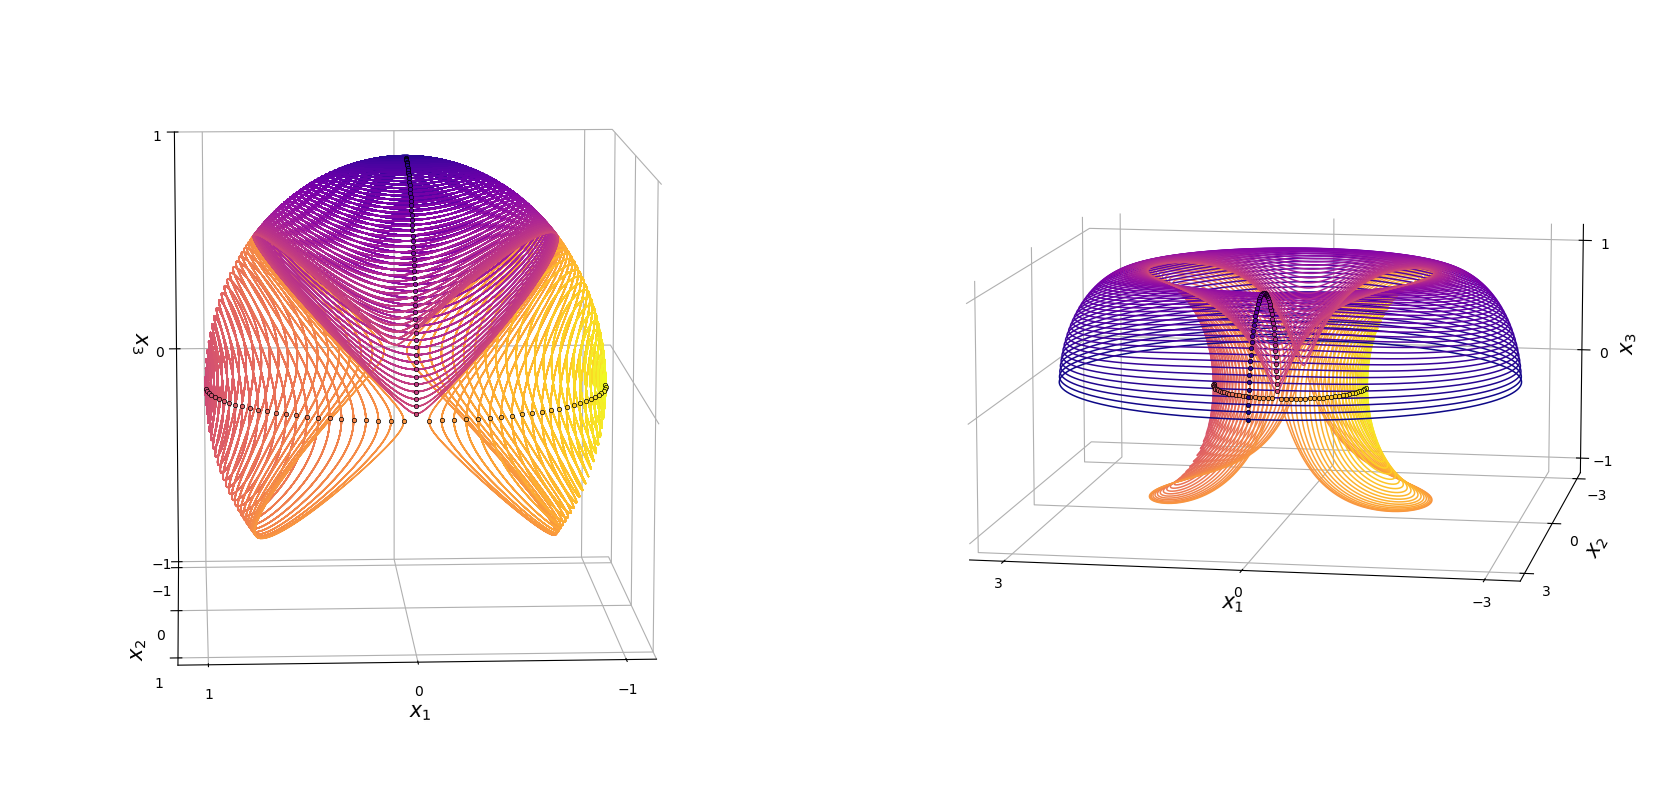

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.patches import FancyArrowPatch

from matplotlib.path import Path
from matplotlib.patches import PathPatch

fig = plt.figure(figsize=(18, 8))
gs  = fig.add_gridspec(nrows=1, ncols=2, wspace=0)

"""
    Sphere
"""
ax1 = fig.add_subplot(gs[0], projection="3d")
idx_order = list(reversed(range(len(x0_lst))))
first_band = idx_order[0]

for _i in idx_order:
    _x0, _data = x0_lst[_i], sphere_data_lst[_i]
    cmap = cmaps[_i]
    n_traj = len(_data)
    norm = colors.Normalize(vmin=0, vmax=max(n_traj - 1, 1))

    for _j, jd in enumerate(_data):
        t = norm(_j)
        color = cmap(t)
        j_x0 = _x0[_j]

        jd_plot = kill_small(jd, 1e-14) 
        j_x0    = kill_small(j_x0, 1e-14)

        if _i == first_band:
            ax1.scatter(j_x0[0], j_x0[1], j_x0[2], color=color, s=10,
                       edgecolors='k', linewidths=0.5)
            ax1.plot(jd_plot[:, 0], jd_plot[:, 1], jd_plot[:, 2], color=color, lw=1.1)
        else:
            ax1.plot(jd_plot[:, 0], jd_plot[:, 1], jd_plot[:, 2], color=color, lw=1.1)
            ax1.scatter(j_x0[0], j_x0[1], j_x0[2], color=color, s=10,
                       edgecolors='k', linewidths=0.5)

ax1.set_box_aspect((1, 1, 1))
ax1.set_xlabel(r"$x_1$", fontsize=15)
ax1.set_ylabel(r"$x_2$", fontsize=15)
ax1.set_zlabel(r"$x_3$", fontsize=15)

ax1.set_xticks([-1, 0, 1])
ax1.set_yticks([-1, 0, 1])
ax1.set_zticks([-1, 0, 1])
ax1.set_zlim([-1, 1])

ax1.xaxis.set_pane_color((1, 1, 1, 0))
ax1.yaxis.set_pane_color((1, 1, 1, 0))
ax1.zaxis.set_pane_color((1, 1, 1, 0))

ax1.view_init(elev=10, azim=87)

"""
    Torus 3D
"""
ax2 = fig.add_subplot(gs[1], projection="3d")

for _i in idx_order:
    _x0, _data = x0_lst[_i], torus_data_lst[_i]
    cmap = cmaps[_i]
    n_traj = len(_data)
    norm = colors.Normalize(vmin=0, vmax=max(n_traj - 1, 1))

    for _j, jd in enumerate(_data):
        t = norm(_j)
        color = cmap(t)
        __, theta, phi = sth.changetotorus_(_x0[_j].reshape(1, 1, -1)) 
        j_x0 = tdg.map_to_torus(theta, phi, 3)[0][0]

        jd_plot = kill_small(jd, 1e-14) 
        j_x0    = kill_small(j_x0, 1e-14)

        if _i == first_band:
            ax2.scatter(j_x0[0], j_x0[1], j_x0[2], color=color, s=10,
                       edgecolors='k', linewidths=0.5)
            ax2.plot(jd_plot[:, 0], jd_plot[:, 1], jd_plot[:, 2], color=color, lw=1.1)
        else:
            ax2.plot(jd_plot[:, 0], jd_plot[:, 1], jd_plot[:, 2], color=color, lw=1.1)
            ax2.scatter(j_x0[0], j_x0[1], j_x0[2], color=color, s=10,
                       edgecolors='k', linewidths=0.5)

ax2.set_box_aspect((1, 1, 0.5))
ax2.set_xlabel(r"$x_1$", fontsize=15)
ax2.set_ylabel(r"$x_2$", fontsize=15)
ax2.set_zlabel(r"$x_3$", fontsize=15)

ax2.set_xticks([-3, 0, 3])
ax2.set_yticks([-3, 0, 3])
ax2.set_zticks([-1, 0, 1])

ax2.xaxis.set_pane_color((1, 1, 1, 0))
ax2.yaxis.set_pane_color((1, 1, 1, 0))
ax2.zaxis.set_pane_color((1, 1, 1, 0))

ax2.view_init(elev=10, azim=100)

fig.tight_layout()

# theta = np.linspace(0, 2*np.pi, 101)

# xc = np.cos(theta)
# yc = np.sin(theta)

# ax1.plot(xc, yc, -1*np.ones(len(theta)), 'k')

# import numpy as np
# from matplotlib.patches import FancyArrowPatch
# from mpl_toolkits.mplot3d import proj3d

# class Arrow3D(FancyArrowPatch):
#     def __init__(self, xs, ys, zs, *args, **kwargs):
#         super().__init__((0, 0), (0, 0), *args, **kwargs)
#         self._verts3d = (np.asarray(xs), np.asarray(ys), np.asarray(zs))

#     def draw(self, renderer):
#         # project 3D -> 2D and draw
#         xs3d, ys3d, zs3d = self._verts3d
#         M = self.axes.get_proj()
#         xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, M)
#         self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
#         super().draw(renderer)

#     def do_3d_projection(self, renderer=None):
#         # needed for depth-sorting in newer Matplotlib
#         xs3d, ys3d, zs3d = self._verts3d
#         M = self.axes.get_proj()
#         xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, M)
#         self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
#         return float(np.min(zs))

# phi = np.pi/4  # pick any angle on the circle
# x1, y1, z1 = np.cos(phi), np.sin(phi), -1.0

# arr = Arrow3D(
#     [0.0, x1], [0.0, y1], [-1.0, z1],
#     arrowstyle="-|>", mutation_scale=20, lw=2.0, color="black"
# )
# ax1.add_artist(arr)


fig.savefig('./pics/torus_figure.pdf', bbox_inches="tight", dpi=500)

## Sphere

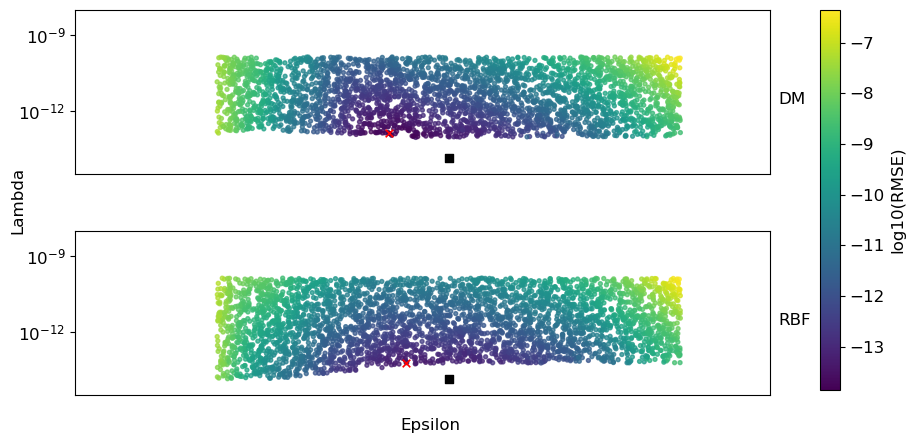

In [ ]:
import os
import numpy as np
import polars as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator

# ---------------------------
# Config
# ---------------------------
devices = 4
modes = ["diffusion", "rbf"]
mode_labels = {"diffusion": "DM", "rbf": "RBF"}
map_type = "skip-connection"
dt = 0.01
plt.rcParams.update({"font.size": 12})

# ---------------------------
# 1) Pre-pass: find global vmin/vmax on log10(RMSE)
# ---------------------------
global_min = np.inf
global_max = -np.inf
existing = {}  # cache: (mode, d, num_points) -> DataFrame

for mode in modes:
    fname = f"numerical_results/sphere_cv_result_{mode}.parquet"
    if not os.path.exists(fname):
        continue
    df = pl.read_parquet(fname)
    existing[(mode)] = df

    rmse = df["rmse"].to_numpy()
    mask = np.isfinite(rmse) & (rmse > 0)
    if not np.any(mask):
        continue
    log_rmse = np.log10(rmse[mask])
    global_min = min(global_min, np.nanmin(log_rmse))
    global_max = max(global_max, np.nanmax(log_rmse))

if not np.isfinite(global_min) or not np.isfinite(global_max):
    raise RuntimeError("No valid RMSE values > 0 found across the provided parquet files.")

# ---------------------------
# 2) Plot with per-subplot domains (no shared axes)
# ---------------------------
nrows = len(modes)
ncols = 1

fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(10, 5),
    sharex=False, sharey=False
)

# Leave a bit more room on the right for the colorbar
fig.subplots_adjust(right=0.82, wspace=0.25, hspace=0.35)

norm = mpl.colors.Normalize(vmin=global_min, vmax=global_max)
cmap = "viridis"

for i_mode, mode in enumerate(modes):
    row = i_mode
    ax = axs[row]

    key = (mode)
    if key not in existing:
        ax.set_visible(False)
        continue

    cv_results = existing[key]
    eps   = cv_results["epsilon"].to_numpy()
    lam   = cv_results["lambda_reg"].to_numpy()   # linear scale
    eps_c = cv_results["epsilon_c"].to_numpy()[0]
    lam_m = cv_results["lambda_min"].to_numpy()[0]  # log10(lambda*)
    rmse  = cv_results["rmse"].to_numpy()

    mask = (
        np.isfinite(rmse) & (rmse > 0) &
        np.isfinite(eps)  & (eps  > 0) &
        np.isfinite(lam)  & (lam  > 0)
    )
    if not np.any(mask):
        ax.set_visible(False)
        continue

    ax.scatter(
        eps[mask],
        lam[mask],
        c=np.log10(rmse[mask]),
        cmap=cmap,
        norm=norm,
        s=8,
        alpha=0.75,
    )

    # mark best in this grid
    idx = np.nanargmin(rmse[mask])
    ax.scatter([eps[mask][idx]], [lam[mask][idx]], c="red", marker="x", s=30, linewidths=1.2)
    ax.scatter(eps_c, 10**lam_m, c="black", marker='s', s=30)

    ax.set_xscale("log")
    ax.set_yscale("log")

    # per-subplot limits (you set fixed domains; keep them)
    ax.set_xlim([10**(-3), 10**(3)])
    ax.set_ylim([10**(-14.5), 10**(-8)])

    # row labels on the right (as in your original)
    ax.set_ylabel(f"{mode_labels[mode]}", rotation=0, labelpad=6, ha="left")
    ax.yaxis.set_label_position("right")

x0 = fig.subplotpars.right + 0.05  # 0.02 = gap from subplots
cbar_ax = fig.add_axes([x0, 0.12, 0.02, 0.76])

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel("log10(RMSE)")

fig.text(0.48, 0.04, "Epsilon", ha="center")
fig.text(0.06, 0.5, "Lambda", va="center", rotation="vertical")

for ax in axs.flat:
    ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False, top=False, labeltop=False)
    ax.tick_params(axis="y", which="both", left=False,  labelleft=False,  right=False, labelright=False)
    ax.minorticks_off()

# sparse locators
x_locator = LogLocator(base=10, numticks=3) 
y_locator = LogLocator(base=10, numticks=3)

for r in range(nrows):
    ax = axs[r]
    ax.tick_params(axis="y", which="both", left=True, labelleft=True)
    ax.yaxis.set_major_locator(y_locator)

# fig.savefig("./pics/sphere_cv_results.pdf", bbox_inches="tight", dpi=500)


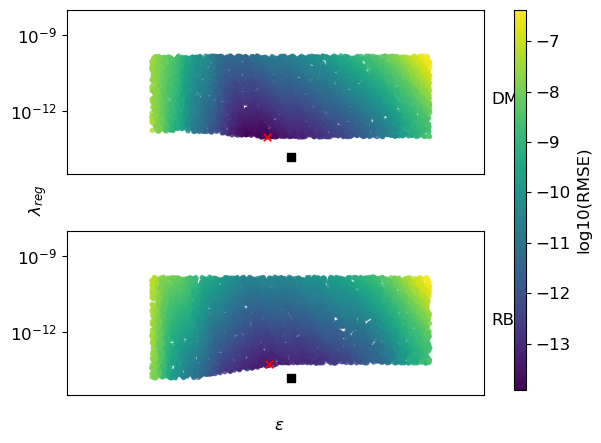

In [2]:
import os
import numpy as np
import polars as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator

# ---------------------------
# Config
# ---------------------------
devices = 4
modes = ["diffusion", "rbf"]
mode_labels = {"diffusion": "DM", "rbf": "RBF"}
map_type = "skip-connection"
dt = 0.01
plt.rcParams.update({"font.size": 12})

# ---------------------------
# 1) Pre-pass: find global vmin/vmax on log10(RMSE)
# ---------------------------
global_min = np.inf
global_max = -np.inf
existing = {}  # cache: (mode, d, num_points) -> DataFrame

for mode in modes:
    fname = f"numerical_results/sphere_cv_result_{mode}.parquet"
    if not os.path.exists(fname):
        continue
    df = pl.read_parquet(fname)
    existing[(mode)] = df

    rmse = df["rmse"].to_numpy()
    mask = np.isfinite(rmse) & (rmse > 0)
    if not np.any(mask):
        continue
    log_rmse = np.log10(rmse[mask])
    global_min = min(global_min, np.nanmin(log_rmse))
    global_max = max(global_max, np.nanmax(log_rmse))

if not np.isfinite(global_min) or not np.isfinite(global_max):
    raise RuntimeError("No valid RMSE values > 0 found across the provided parquet files.")

# ---------------------------
# 2) Plot with per-subplot domains (no shared axes)
# ---------------------------
nrows = len(modes)
ncols = 1

fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(6, 5),
    sharex=False, sharey=False
)

# Leave a bit more room on the right for the colorbar
fig.subplots_adjust(right=0.82, wspace=0.25, hspace=0.35)

norm = mpl.colors.Normalize(vmin=global_min, vmax=global_max)
cmap = "viridis"

for i_mode, mode in enumerate(modes):
    row = i_mode
    ax = axs[row]

    key = (mode)
    if key not in existing:
        ax.set_visible(False)
        continue

    cv_results = existing[key]
    eps   = cv_results["epsilon"].to_numpy()
    lam   = cv_results["lambda_reg"].to_numpy()   # linear scale
    eps_c = cv_results["epsilon_c"].to_numpy()[0]
    lam_m = cv_results["lambda_min"].to_numpy()[0]  # log10(lambda*)
    rmse  = cv_results["rmse"].to_numpy()

    mask = (
        np.isfinite(rmse) & (rmse > 0) &
        np.isfinite(eps)  & (eps  > 0) &
        np.isfinite(lam)  & (lam  > 0)
    )
    if not np.any(mask):
        ax.set_visible(False)
        continue

    ax.scatter(
        eps[mask],
        lam[mask],
        c=np.log10(rmse[mask]),
        cmap=cmap,
        norm=norm,
        s=8,
        alpha=0.75,
    )

    # mark best in this grid
    idx = np.nanargmin(rmse[mask])
    ax.scatter([eps[mask][idx]], [lam[mask][idx]], c="red", marker="x", s=30, linewidths=1.2)
    ax.scatter(eps_c, 10**lam_m, c="black", marker='s', s=30)

    ax.set_xscale("log")
    ax.set_yscale("log")

    # per-subplot limits (you set fixed domains; keep them)
    ax.set_xlim([10**(-3), 10**(3)])
    ax.set_ylim([10**(-14.5), 10**(-8)])

    # row labels on the right (as in your original)
    ax.set_ylabel(f"{mode_labels[mode]}", rotation=0, labelpad=6, ha="left")
    ax.yaxis.set_label_position("right")

x0 = fig.subplotpars.right + 0.05  # 0.02 = gap from subplots
cbar_ax = fig.add_axes([x0, 0.12, 0.02, 0.76])

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel("log10(RMSE)")

fig.text(0.48, 0.04, r"$\varepsilon$", ha="center")
fig.text(0.06, 0.5, r"$\lambda_{reg}$", va="center", rotation="vertical")

for ax in axs.flat:
    ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False, top=False, labeltop=False)
    ax.tick_params(axis="y", which="both", left=False,  labelleft=False,  right=False, labelright=False)
    ax.minorticks_off()

# sparse locators
x_locator = LogLocator(base=10, numticks=3) 
y_locator = LogLocator(base=10, numticks=3)

for r in range(nrows):
    ax = axs[r]
    ax.tick_params(axis="y", which="both", left=True, labelleft=True)
    ax.yaxis.set_major_locator(y_locator)

# fig.savefig("./pics/sphere_cv_results.pdf", bbox_inches="tight", dpi=500)


In [3]:
map_type = "skip-connection"
dt = 0.01
mode = "diffusion"
test_results = pl.read_parquet(f"numerical_results/sphere_test_result_{mode}_2048_{map_type}_dt_{dt}.parquet")
rmse = test_results["rmse"].to_numpy()
print(np.mean(rmse))

mode = "rbf"
test_results = pl.read_parquet(f"numerical_results/sphere_test_result_{mode}_2048_{map_type}_dt_{dt}.parquet")
rmse = test_results["rmse"].to_numpy()
print(np.mean(rmse))

test_results = pl.read_parquet(f"numerical_results/sphere_sindy_test_result_2048.parquet")
rmse = test_results["rmse"].to_numpy()
print(np.mean(rmse))

6.135002153149283e-14
3.160209223061988e-13
6.034368811030425e-13


## Torus

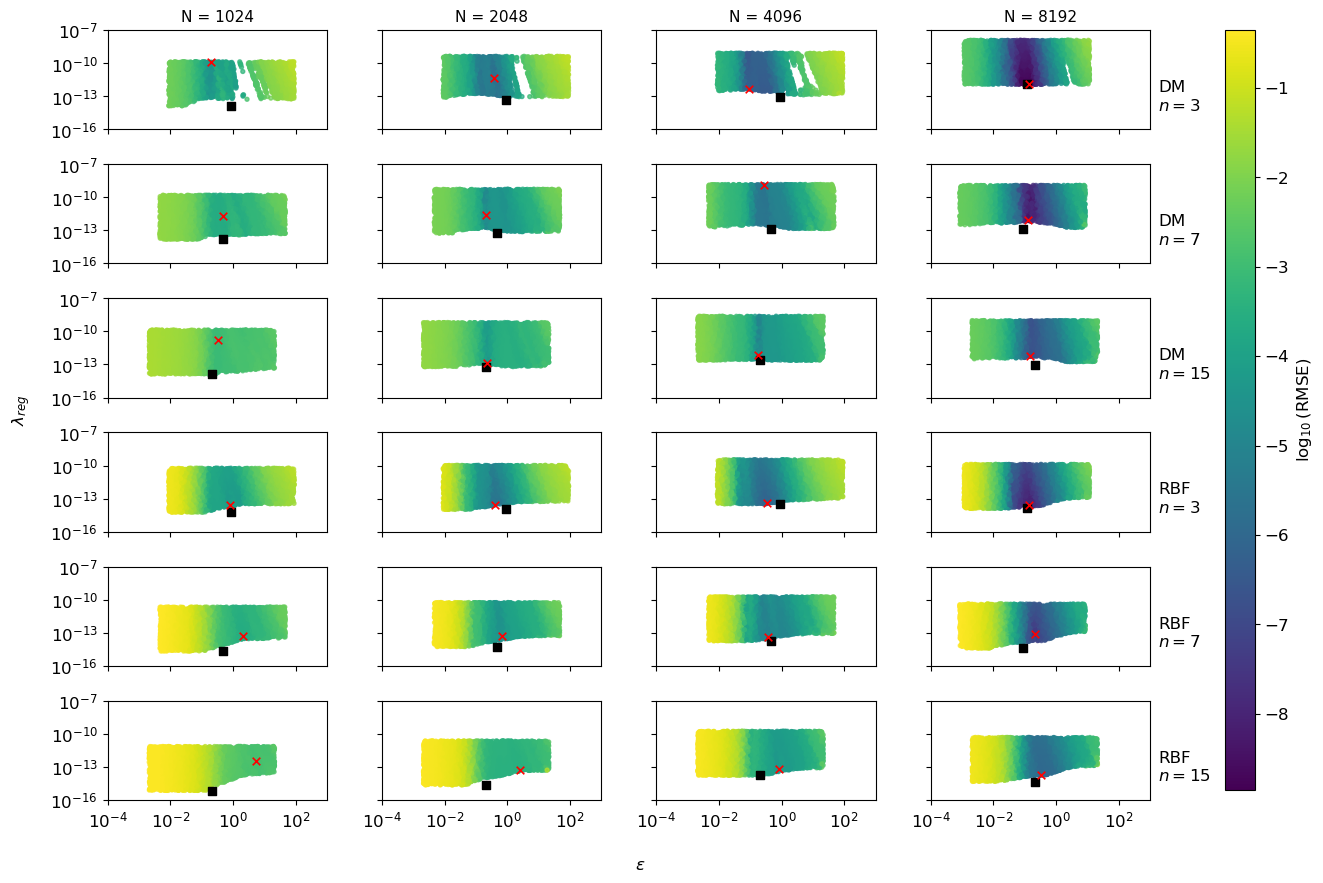

In [9]:
import os
import numpy as np
import polars as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator


devices = 4
modes = ["diffusion", "rbf"]
mode_labels = {"diffusion": "DM", "rbf": "RBF"}
num_points_lst = [1024, 2048, 4096, 8192]
map_type = "skip-connection"
dt = 0.01
d_lst = [3, 7, 15]
plt.rcParams.update({"font.size": 12})

global_min = np.inf
global_max = -np.inf
existing = {} 

for mode in modes:
    for d in d_lst:
        for num_points in num_points_lst:
            fname =  f"/home/jzs6565/diffusion_maps/trained_mdls/torus/torus_{d}d_cv_result_{mode}_{num_points}_{map_type}_dt_{dt}.parquet"
            if not os.path.exists(fname):
                continue
            df = pl.read_parquet(fname)
            existing[(mode, d, num_points)] = df

            rmse = df["rmse"].to_numpy()
            mask = np.isfinite(rmse) & (rmse > 0)
            if not np.any(mask):
                continue
            log_rmse = np.log10(rmse[mask])
            global_min = min(global_min, np.nanmin(log_rmse))
            global_max = max(global_max, np.nanmax(log_rmse))

if not np.isfinite(global_min) or not np.isfinite(global_max):
    raise RuntimeError("No valid RMSE values > 0 found across the provided parquet files.")

nrows = len(modes) * len(d_lst)
ncols = len(num_points_lst)

fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(15, 10),
    sharex=False, sharey=False
)

fig.subplots_adjust(right=0.82, wspace=0.25, hspace=0.35)

norm = mpl.colors.Normalize(vmin=global_min, vmax=global_max)
cmap = "viridis"

for i_mode, mode in enumerate(modes):
    for j_d, d in enumerate(d_lst):
        row = len(d_lst) * i_mode + j_d

        for j, num_points in enumerate(num_points_lst):
            ax = axs[row, j]

            key = (mode, d, num_points)
            if key not in existing:
                ax.set_visible(False)
                continue

            cv_results = existing[key]
            eps   = cv_results["epsilon"].to_numpy()
            lam   = cv_results["lambda_reg"].to_numpy()
            eps_c = cv_results["epsilon_c"].to_numpy()[0]
            lam_m = cv_results["lambda_min"].to_numpy()[0]
            rmse  = cv_results["rmse"].to_numpy()

            mask = (
                np.isfinite(rmse) & (rmse > 0) &
                np.isfinite(eps)  & (eps  > 0) &
                np.isfinite(lam)  & (lam  > 0)
            )
            if not np.any(mask):
                ax.set_visible(False)
                continue

            ax.scatter(
                eps[mask],
                lam[mask],
                c=np.log10(rmse[mask]),
                cmap=cmap,
                norm=norm,
                s=8,
                alpha=0.75,
            )

            idx = np.nanargmin(rmse[mask])
            ax.scatter([eps[mask][idx]], [lam[mask][idx]], c="red", marker="x", s=30, linewidths=1.2, zorder=10)
            ax.scatter(eps_c, 10**lam_m, c="black", marker='s', s=30)

            ax.set_xscale("log")
            ax.set_yscale("log")

            ax.set_xlim([10**(-4), 10**(3)])
            ax.set_ylim([10**(-16), 10**(-7)])

            if row == 0:
                ax.set_title(f"N = {num_points}", fontsize=11)

            if j == ncols - 1:
                ax.set_ylabel(f"{mode_labels[mode]}\n$n={d}$", rotation=0, labelpad=6, ha="left")
                ax.yaxis.set_label_position("right")

x0 = fig.subplotpars.right + 0.05
cbar_ax = fig.add_axes([x0, 0.12, 0.02, 0.76])

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel(r"$\log_{10}(\mathrm{RMSE})$")


fig.text(0.48, 0.04, r"$\epsilon$", ha="center", fontsize=12)
fig.text(0.06, 0.5, r"$\lambda_{reg}$", va="center", rotation="vertical", fontsize=12)


x_locator = LogLocator(base=10, numticks=3)
y_locator = LogLocator(base=10, numticks=4)

for ax in axs.flat:

    ax.tick_params(
        axis="x",
        which="both",
        bottom=True,
        top=False,
        labelbottom=False
    )
    ax.tick_params(
        axis="y",
        which="both",
        left=True, 
        right=False,
        labelleft=False
    )

    ax.xaxis.set_major_locator(x_locator)
    ax.yaxis.set_major_locator(y_locator)
    ax.minorticks_off()

for r in range(nrows):
    ax = axs[r, 0]
    ax.tick_params(axis="y", which="both", left=True, labelleft=True)
    ax.yaxis.set_major_locator(y_locator)

for c in range(ncols):
    ax = axs[nrows - 1, c]
    ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)
    ax.xaxis.set_major_locator(x_locator)

fig.savefig("./pics/torus_cv_results.png", bbox_inches="tight", dpi=600, transparent=True)


['/home/jzs6565/.conda/envs/dm_env/lib/python39.zip', '/home/jzs6565/.conda/envs/dm_env/lib/python3.9', '/home/jzs6565/.conda/envs/dm_env/lib/python3.9/lib-dynload', '', '/home/jzs6565/.conda/envs/dm_env/lib/python3.9/site-packages']


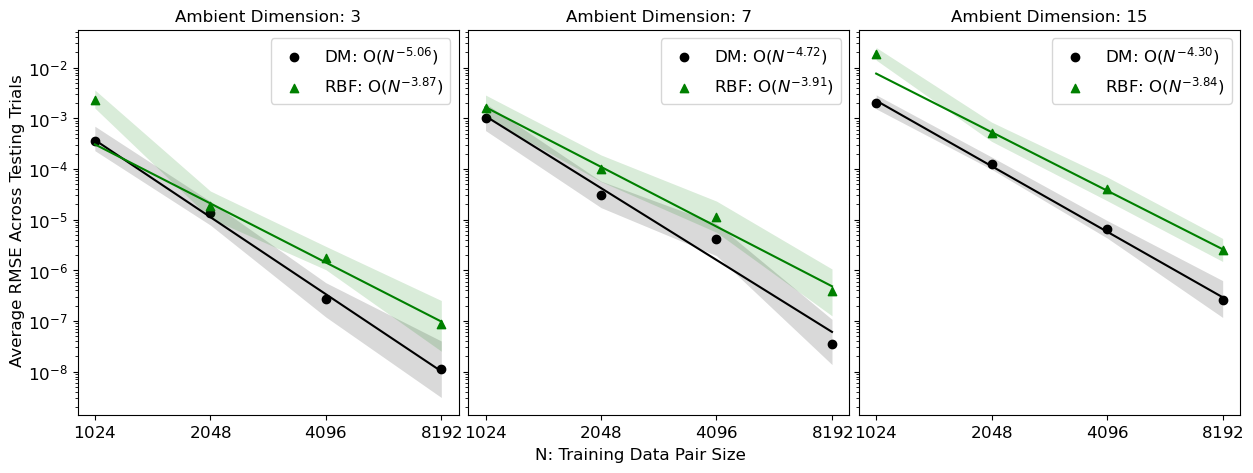

In [8]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter, FixedLocator
# from diffusion_maps import model_dir
import sys
print(sys.path)

def log2_formatter(x, pos):
    return f"$2^{{{int(np.log2(x))}}}$"

num_points_array = [1024, 2048, 4096, 8192]
modes = ["diffusion", "rbf"]
mode_to_label = {"diffusion": "DM", "rbf": "RBF"}
dim_list = [3, 7, 15]
mode_to_color = {"diffusion": "black", "rbf": "green"}
mode_to_marker = {"diffusion": "o", "rbf": "^"}
map_type = "skip-connection"
dt = 0.01

plt.rcParams.update({"font.size": 12})
fig, axs = plt.subplots(1, len(dim_list), figsize=(15, 5), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.025)



for ax, dim in zip(axs, dim_list):
    for mode in modes:
        means, mins, maxs, xs = [], [], [], []

        for num_points in num_points_array:
            try:
                path =  f"/home/jzs6565/diffusion_maps/trained_mdls/torus/torus_{dim}d_test_result_{mode}_{num_points}_{map_type}_dt_{dt}.parquet"
                results = pl.read_parquet(path)
                r = results["rmse"].to_numpy()
                if r.size == 0 or not np.all(np.isfinite(r)):
                    continue

                xs.append(num_points)
                means.append(np.mean(r))
                mins.append(np.min(r))
                maxs.append(np.max(r))
            except Exception:
                # file missing or unreadable: skip silently
                continue

        if len(xs) == 0:
            continue

        # sort by N so the band draws correctly
        if mode == "rbf" and (dim == 3 or dim == 15):
            filt = [1, 2 ,3]
        else:
            filt = [0, 1, 2, 3]
            
        xs = np.array(xs)
        means = np.array(means)
        mins = np.array(mins)
        maxs = np.array(maxs)

        # Power-law fit on means if we have >=2 points
        label_text = mode_to_label[mode]
        if len(xs) >= 2 and np.all(means > 0):
            m, c = np.polyfit(np.log(xs[filt]), np.log(means[filt]), 1)
            fit_y = np.exp(m * np.log(xs) + c)
            line_label = f"{label_text}: O$\\left(N^{{{m:.2f}}}\\right)$"
        else:
            fit_y = None
            line_label = label_text

        # Min–max band
        ax.fill_between(xs, mins, maxs, alpha=0.15, step=None,
                        linewidth=0, color=mode_to_color[mode])

        # Mean points
        ax.scatter(xs, means,
                   color=mode_to_color[mode],
                   marker=mode_to_marker[mode],
                   label=line_label)

        # Fitted trend
        if fit_y is not None:
            ax.plot(xs, fit_y, color=mode_to_color[mode], linewidth=1.5)

    ax.set_title(f"Ambient Dimension: {dim}", fontsize=12)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.set_xticks([2**10, 2**11, 2**12, 2**13])
    ax.set_xticklabels(["$1024$", "$2048$", "$4096$", "$8192$"])
    ax.legend()

fig.text(0.5, 0.02, "N: Training Data Pair Size", ha="center", fontsize=12)
fig.text(
    0.08, 0.5,
    "Average RMSE Across Testing Trials",
    va="center",
    rotation="vertical",
    fontsize=12
)

plt.savefig("./pics/torus_test_rmse.png", bbox_inches="tight", dpi=600, transparent=True)

100%|██████████| 1000/1000 [00:08<00:00, 118.34it/s]


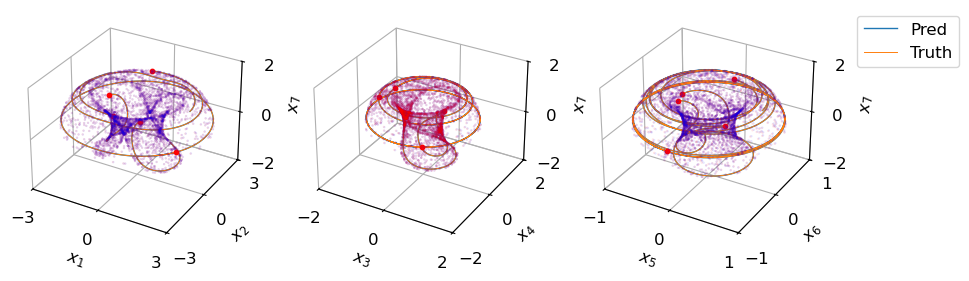

In [4]:
import general_utils_legacy

import sphere_torus_utils.torus_data_gen as tdg
import sphere_torus_utils.sphere_torus_helpers as sth

import numpy as np
import cupy as cp
import pickle
import polars as pl

from joblib import Parallel, delayed

from tqdm import tqdm

from matplotlib import pyplot as plt


np.set_printoptions(precision=16)



filename_training = lambda u, N, d: f"cached_data/torus_training_data_{u}_{N}_{d}.npy"
filename_validation = lambda u, N, d: f"cached_data/torus_validation_data_{u}_{N}_{d}.npy"



mode = 'diffusion'
# mode = 'rbf'
num_points = 4096 #8192
devices = 4
d = 7
map_type = 'skip-connection'
title = f"torus_{d}d"
dt = 0.01

cv_results = pl.read_parquet(
    f"numerical_results/{title}_cv_result_{mode}_{num_points}_{map_type}_dt_{dt}.parquet"
)

epsilon_array = cv_results["epsilon"].to_numpy()
lambda_reg_array = cv_results["lambda_reg"].to_numpy()
rmse_array = cv_results["rmse"].to_numpy()

parted_epsilon_array = np.array_split(epsilon_array, devices)
parted_lambda_reg_array = np.array_split(lambda_reg_array, devices)
parted_rmse_array = np.array_split(rmse_array, devices)

index_array = np.array([np.nanargmin(parted_rmse_array[i]) for i in range(devices)])
best_epsilon_array = np.array(
    [parted_epsilon_array[i][index_array[i]] for i in range(devices)]
    )
best_lambda_reg_array = np.array(
    [parted_lambda_reg_array[i][index_array[i]] for i in range(devices)]
    )
best_idx = np.nanargmin(rmse_array)
best_epsilon = epsilon_array[best_idx]
best_lambda_reg = lambda_reg_array[best_idx]

training_data_x = np.load(filename_training("x",num_points, d))
training_data_y = np.load(filename_training("y",num_points, d))


model = general_utils_legacy.modeler(
        inp=training_data_x, out=training_data_y, map_type=map_type, norm=False
        )
model.fit_model(best_epsilon, best_lambda_reg, mode)
steps = 1000

_x0 = np.load(f'./cached_data/sphere_test_data.npy')[:2000]
truePath = sth.generateData_(_x0, steps * dt, dt)
# convert to torus
truePath, theta, phi = sth.changetotorus_(truePath)
truePath = tdg.map_to_torus_(theta, phi, d)
x0 = cp.array(np.copy(truePath[0]))
pred_path = [cp.copy(x0)]
for i in tqdm(range(steps)):
    x0 = model.forecast(x0)
    pred_path.append(cp.copy(x0))

pred_path = cp.array(pred_path)
truePath = cp.array(truePath)

error = (cp.mean(
        cp.mean(
            (pred_path - truePath)**2, axis=-1), axis=0)
        )
idx = np.argmax(error)

nan_mask = np.isnan(pred_path[:, :, 0])
nan_count = 0
num_nan = np.count_nonzero(nan_mask)
nan_indices = np.where(nan_mask)[0]
nan_loc = np.argwhere(np.isnan(pred_path[:, :, 0]))

truePath = truePath.get()
t = np.linspace(0, int(dt*steps), steps + 1)


pred_path = pred_path.get()
fig = plt.figure(figsize=(12, 6))
ms = 760
m = 5

for idx in range(d//2):

    ax = fig.add_subplot(1,d//2,idx+1, projection='3d')
    ax.scatter(training_data_x[:, 2*idx], training_data_x[:, 2*idx+1], training_data_x[:, -1], facecolors='none', edgecolors='blue',s=0.5, alpha=0.1)
    ax.scatter(training_data_y[:, 2*idx], training_data_y[:, 2*idx+1], training_data_y[:, -1], facecolors='none', edgecolors='red',s=0.5,alpha=0.1)
    for _i in range(5):
        _ = _i + ms
        l1, = ax.plot(pred_path[:, _, 2*idx], pred_path[:, _, 2*idx+1], pred_path[:, _, -1], color='#1f77b4', linewidth=1.0)
        l2, = ax.plot(truePath[:, _, 2*idx], truePath[:, _, 2*idx+1], truePath[:, _, -1], color='#ff7f0e',linewidth=0.7)
        ls = ax.scatter(truePath[0, _, 2*idx], truePath[0, _, 2*idx+1], truePath[0, _, -1], c='r', s=10)
        ax.set_xlabel(rf'$x_{2*idx+1}$')
        ax.set_ylabel(rf'$x_{2*idx+2}$')
        ax.set_zlabel(rf'$x_{d}$')
    xmax = np.ceil(np.max(truePath[:, :, 2*idx]))
    ymax = np.ceil(np.max(truePath[:, :, 2*idx+1]))
    zmax = np.ceil(np.max(truePath[:, :, -1]))

    ax.set_xlim([-xmax, xmax])
    ax.set_ylim([-ymax, ymax])
    ax.set_zlim([-zmax, zmax])
    if idx == d//2 - 1:
        ax.legend([l1, l2], ['Pred', 'Truth'], bbox_to_anchor=(1.10, 1.01), loc='upper left', fontsize=12)
    ax.set_xticks([-xmax, 0, xmax])
    ax.set_yticks([-ymax, 0, ymax])
    ax.set_zticks([-zmax, 0, zmax])
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    if idx == d//2 - 1:
        handles = [l1, l2]
        labels  = ['Pred', 'Truth']
# fig.tight_layout()                 # auto-pack
fig.subplots_adjust(right=0.80)  
fig.savefig(f'./journal_pics/torus_{d}d_{mode}_{num_points}.png', bbox_inches='tight', dpi=600, transparent=True)

# fig, ax  = plt.subplots(nrows=3, ncols=1, sharex=True)
# for _ in range(92, 97):

#     l1, = ax[0].plot(t, pred_path[:, _, 0], linewidth=1.0, color='#1f77b4')
#     ax[1].plot(t, pred_path[:, _, 1], linewidth=1.0, color='#1f77b4')
#     ax[2].plot(t, pred_path[:, _, 2], linewidth=1.0, color='#1f77b4')

#     l2, = ax[0].plot(t, truePath[:, _, 0],  linewidth=0.7, color='#ff7f0e')
#     ax[1].plot(t, truePath[:, _, 1], linewidth=0.7, color='#ff7f0e')
#     ax[2].plot(t, truePath[:, _, 2], linewidth=0.7, color='#ff7f0e')

#     #ax[0].set_ylim([np.min(truePath[:, _, 0])*1.1, np.max(truePath[:, _, 0])*1.1])
#     #ax[1].set_ylim([np.min(truePath[:, _, 1])*1.1, np.max(truePath[:, _, 1])*1.1])
#     #ax[2].set_ylim([np.min(truePath[:, _, 2])*1.1, np.max(truePath[:, _, 2])*1.1])
# ax[0].legend([l1, l2], ['Pred', 'Truth'])
# ax[2].set_xlabel('$t$', fontsize=15)
# ax[0].set_ylabel('$x_1$', fontsize=15)
# ax[1].set_ylabel('$x_2$', fontsize=15)
# ax[2].set_ylabel('$x_3$', fontsize=15)
# fig.savefig(f'./pics/torus_{d}d_states_{mode}_{num_points}.png', bbox_inches='tight', dpi=500)
